In [1]:
from helper import ELBO_Mix, ELBO_Simple, ELBO_Choice
from helper import empirical_coverage, nll, get_data
from scipy.stats import invgamma as invgamma, uniform as uniform, norm as gaussian
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
%matplotlib inline


### Define simulated data

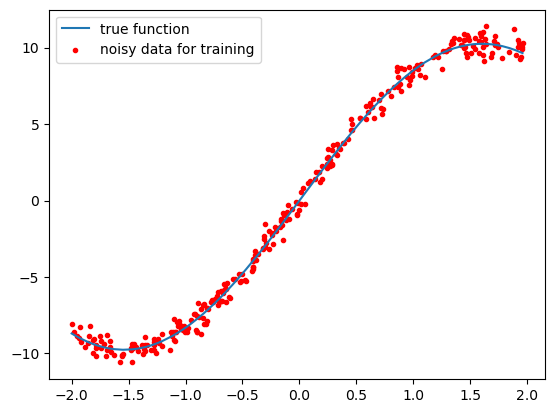

In [2]:
def some_function(x): 
    return 10*np.sin(x[:,0]) + 0.1*x[:,0]**2

rng = np.random.default_rng(seed=36)

N = 300
D_x = 2

x_simulated = np.array([uniform.rvs(-2, 4, N, random_state = rng) for _ in range(D_x)]).T
noise = gaussian.rvs(0, 0.5, (N,1), random_state = rng)
y_simulated_noise = (some_function(x_simulated).reshape(N,1) + noise)
y_simulated_true = (some_function(x_simulated)).reshape(N,1)



idx = np.argsort(x_simulated[:,0])


plt.plot(x_simulated[:,0][idx], y_simulated_true[idx],  label = 'true function')
plt.scatter(x_simulated[:, 0], y_simulated_noise, marker ='.',  color = 'red', label = 'noisy data for training')

plt.legend()

### Split and scale data

In [3]:
X_t, X_p, Y_t, Y_p = get_data(x_simulated, y_simulated_noise, 647, 0.1)

### Parameters to give to the 'ELBO_choice' or 'ELBO_Simple'
If using 'ELBO_Mix', then delete "wb_mode" entry.  

In [4]:
parameters_choice = {
"x"        : X_t,
"y"     :  Y_t,
"D_a"   : 20, 
"L"     :  1,
"T"     : 0.1,
"wb_mode"  : 'laplace', 
"big_S" : 0.01
}

parameters_choice_mix = {
"x"        : X_t,
"y"     :  Y_t,
"D_a"   : 20, 
"L"     :  1,
"T"     : 0.1, 
"big_S" : 0.01
}


#### Example of using 'ELBO_Simple'

In [ ]:
m = ELBO_Simple(parameters_choice)
m.model_choice(x_new = X_p, runs =10, epochs = 100, epochs_pred=40, rate = 1e-5, rate_pred=1e-5)


In [ ]:
prediction = m.prediction
prediction_std = m.prediction_std


print('The metrics are:')
print('R2 score:', r2_score(Y_p, prediction))
print('NLL:', nll(Y_p, prediction, prediction_std))
print('Coverage:', empirical_coverage(Y_p, prediction, prediction_std))

The metrics are:
R2 score: 0.9939609295192756
NLL: 0.909649
Coverage: 1.0


### Or can create an ensemble (small one)

In [6]:
m = ELBO_Mix(parameters_choice_mix)
m.model_ensemble(x_new = X_p, epochs = 100, epochs_pred=40, rate = 1e-5, rate_pred=1e-5, tau =1)

In [7]:
prediction = m.prediction
prediction_std = m.prediction_std


print('The metrics are:')
print('R2 score:', r2_score(Y_p, prediction))
print('NLL:', nll(Y_p, prediction, prediction_std))
print('Coverage:', empirical_coverage(Y_p, prediction, prediction_std))

The metrics are:
R2 score: 0.9934057009376129
NLL: 0.9527529
Coverage: 1.0


#### Plot predictions

Text(0.5, 0, '$x_1$')

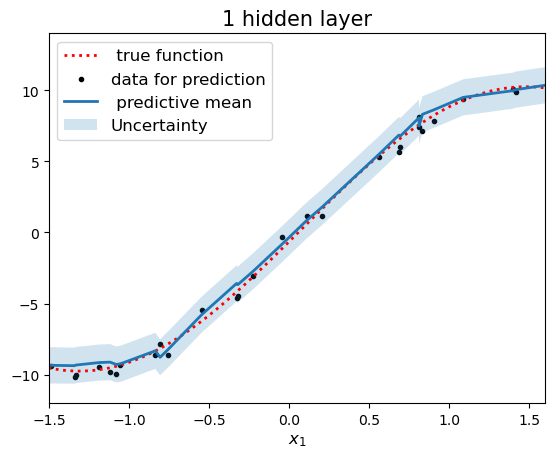

In [9]:

scaler = preprocessing.StandardScaler().fit(x_simulated)
X_scaled = scaler.transform(x_simulated)
idx = np.argsort(X_scaled[:,0])

plt.figure()
# plt.figure(dpi = 300)
plt.plot(X_scaled[:,0][idx], y_simulated_true[idx], linestyle = ':', linewidth = 2, color = 'red', label = ' true function')

plt.scatter(X_p[:, 0], Y_p, marker = '.', color = 'black', label = 'data for prediction')
xidx = (X_p[:, 0].reshape(-1)).argsort()
plt.plot(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx], linewidth = 2, label= ' predictive mean')
plt.fill_between(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] - 2*prediction_std.reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] + 2* prediction_std.reshape(-1)[xidx], alpha = 0.2, label = 'Uncertainty')



plt.xlim(-1.5, 1.6)
plt.ylim(-12, 14)
plt.title(str(m.L) + ' hidden layer', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 12)
plt.xlabel(r'$x_1$', fontsize = 12)

#### Example of using 'ELBO_Choice'in order to access the model, its weights and sparse predictions

In [10]:

m = ELBO_Choice(parameters_choice)
model = m.model_choice(runs = 1,  epochs=140, rate = 1e-6, dm = True)

done training epochs:  140
elbo:  -10965.191630668887


In [11]:

prediction = model.predict(X_p, 40, 1e-5)
prediction_std = np.sqrt(model.var_tot)

In [12]:


alpha = 1e-3
epsilon = 0.1
y_model_sparse = model.sparse_predict(x_for_pred=X_p, epochs_pred = 30, alpha =alpha, epsilon = 0.1)
var_tot_sparse = np.copy(model.var_tot)

----
done, kappa upon which we threshold is  0.9542006822496503


#### Plot predictions/sparse predictions

Text(0.5, 0, '$x_1$')

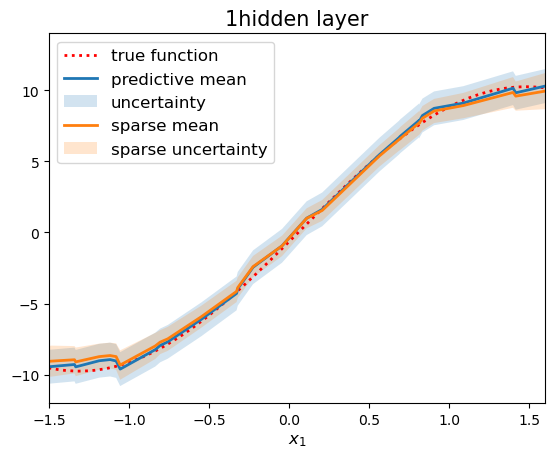

In [13]:

scaler = preprocessing.StandardScaler().fit(x_simulated)
X_scaled = scaler.transform(x_simulated)
idx = np.argsort(X_scaled[:,0])

plt.figure()
# plt.figure(dpi = 300)
plt.plot(X_scaled[:,0][idx], y_simulated_true[idx], linestyle = ':', linewidth = 2, color = 'red', label = 'true function')

xidx = (X_p[:, 0].reshape(-1)).argsort()
plt.plot(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx], linewidth = 2, label= 'predictive mean')
plt.fill_between(X_p[:, 0].reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] - 2*prediction_std.reshape(-1)[xidx], prediction.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] + 2* prediction_std.reshape(-1)[xidx], alpha = 0.2, label = 'uncertainty')


plt.plot(X_p[:, 0].reshape(-1)[xidx], y_model_sparse.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx], linewidth = 2, label= 'sparse mean')
plt.fill_between(X_p[:, 0].reshape(-1)[xidx], y_model_sparse.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] - 2*var_tot_sparse.reshape(-1)[xidx], y_model_sparse.reshape(Y_p.shape)[:, 0].reshape(-1)[xidx] + 2* var_tot_sparse.reshape(-1)[xidx], alpha = 0.2, label = 'sparse uncertainty')



plt.xlim(-1.5, 1.6)
plt.ylim(-12, 14)
plt.title(str(model.L) + 'hidden layer', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 12)
plt.xlabel(r'$x_1$', fontsize = 12)

In [ ]:

W_stars, listik = model.sparse_weighs(alpha=1e-, epsilon=0.1)


G_after = nx.DiGraph(listik)


listik = list(set(sum(listik, ())))
for node in listik:
        G_after.nodes[node]["layer"] = node[0]

pos_after = nx.multipartite_layout(G_after, subset_key="layer")
fig, ax = plt.subplots(1, dpi = 100)
nx.draw_networkx(G_after, pos=pos_after, ax=ax, with_labels = False, node_size = 80)
plt.show()